<h1>Multi-Touch Attribution with First-Order Markov Chains</h1>

The purpose of this notebook is to demonstrate the capabilities of Markov chains in measuring relative effectiveness of each channel in the multi-touch journey of consumers from start to conversion. Attribution of a channel is measured as its contribution towards the total number of conversions. First-order Markov chains model customer journeys through different channel according to the Markov process. A channel attribution, in this setting, is calculated by measuring the drop in conversions when that channel is removed from the Markov chain.

## 1. Introduction <a name="se:intro"></a>

A Markov process is a stochastic process describing a sequence of possible events satisfying the Markov property, i.e., memorylessness. A Markov chain is a series of `states` which are visited sequentially by some probability. The Markov property governs transition probabilities of a Markov chain from one state to another under which these probabilities only depend on the current state and are memoryless with respect to previous states. 

In multi-touch attribution settings, customer journeys through different channels can be modeled via a Markov chain where different channels construct the state space of the Markov model. For an illustrating example, the Markov property indicates that the probability of the transitioning from state `NATURAL SEARCH|MOBILE` to state `PAID SEARCH|DESKTOP` in the two following customer journeys is the same.

*journey1*: <span style="color:blue">NATURAL SEARCH|MOBILE --> PAID SEARCH|DESKTOP</span> --> DISPLAY|MOBILE --> CONVERSION 

*journey2*: DIRECT|MOBILE --> EMAIL|MOBILE --> <span style="color:blue">NATURAL SEARCH|MOBILE --> PAID SEARCH|DESKTOP</span> --> CONVERSION

A Markov chain can also include **absorbing states** from which no further transitions are possible. In multi-touch attribution settings, absorbing states are used to model conversion or loss of a customer since after these states, the customer journey ends. A first-order Markov chain refers to a definition of state variable which only records current events. A higher-order Markov chain will aggregate a series of state into a single state which forces the transition probabilities to depend on a series of events. **NOTE** that even in higher order Markov chain, the Markov property is satisfied since each transition only depends on the current state eventhough the current state is itself a series of state visits.

![MCv1](MCv1.png)

The figure above describes a **discrete-time first-order Markov chain** model of the multi-touch attribution setting. This is a ***discrete-time*** model since transitions (hence transition probabilities) do not depend on the time of interaction. For example, a customer's transition from `NATURAL SEARCH|MOBILE` to `PAID SEARCH|DESKTOP` does not depend on the time that has passed since the customer visited `NATURAL SEARCH|MOBILE`. It is a ***first-order*** model since transitions only depend on the latest channel that was visited and do not consider previous visits. The Markov chain also has two absorbing states, `LOSS` and `CONVERSION` where customer journey end into.

Attribution in a Markov chain model is evaluated by removing a channel from the chain and measure the difference in total number of conversions. Removing a channel from the Markov chain results in loosing transitions to and from that channel and thus, a certain number of customer journeys are assumed to be lost. This is a limiting assumption as removing a channel might not result in loss of a customer and the customer might utilize other channels to convert. For more details, refer to [Section 4](#se:attribution).

## 2. Read-in sample data base <a name="se:data"></a>

A sample data base is provided which consists of `601776` customer identifier keys and the customer journeys to conversion or loss. Customer journeys are created from raw customer interactions (clicks, impressions, etc.) where individual interactions are grouped by an customer identifer key (e.g., cookie id), sorted by a timestamp (e.g., time of interaction) and joined together. For more details, refer to [Data Transformation](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Data%20Transformations/index.html) section of [Customer Journey Analytics](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/index.html). The sample data set is investigated to see no duplicate values are present in customer IDs. **NOTE** that this data set assumes only a homogeneous set of consumers.

In [1]:
import os
import inspect
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(curr_dir)
path_df = pd.read_csv(os.path.join(parent_dir, 
                                   "../Data Transformations/raw data/customer_journey_sample_data.csv"), 
                      index_col = 0)
print(f'The data frame includes {list(path_df.columns)} columns \
and {len(path_df.PGM_FREQ_MEMBER_KEY.unique())} distinct rows')
path_df.head(5)

The data frame includes ['PGM_FREQ_MEMBER_KEY', 'CAM_DEV', 'CONVERSION'] columns and 601776 distinct rows


,PGM_FREQ_MEMBER_KEY,CAM_DEV,CONVERSION
0,-9223328556171841832,"['NATURAL SEARCH|DESKTOP', 'REFERRAL ENGINE|DE...",1
1,-9223242021294710602,"['NATURAL SEARCH|DESKTOP', 'PAID SEARCH|DESKTOP']",1
2,-9223227354203035958,['DIRECT|DESKTOP'],0
3,-9223216806413203389,"['DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP']",1
4,-9223197902225736847,"['NATURAL SEARCH|DESKTOP', 'DIRECT|DESKTOP', '...",1


**Stiching customer journeys**: The current customery journey stored in `path_df.CAM_DEV` only include channel visits and do not have any starting or absorbing point. The following function, `add_start_absorbing_state_func` produces a complete journey for each customer path in `path_df` data frame.

In [2]:
def add_start_absorbing_state_func(conversion, path):
    import ast
    path = ast.literal_eval(path)
    if conversion == 0:
        return ['Start'] + path + ['LOSS']
    else: 
        return ['Start'] + path + ['CONVERSION']

In [3]:
path_df['FULL_PATH'] = path_df.apply(lambda x: add_start_absorbing_state_func(x['CONVERSION'], x['CAM_DEV']), axis = 1)

**Dimension Reduction**: To simply the analysis and ease the computation effort, some of the states in the `unique_state_lst` are grouped together into `OTHER`. <span style="color:blue">**NOTE** that by leaving the `other_state_lst` list empty, the following Markov chain analyses will consider all the original states.</span>

In [4]:
#extract all the unique states that are visited along all paths
unique_channel_lst = set(state for path in path_df.FULL_PATH for state in path)
print(unique_channel_lst)

{'AFFILIATE|DESKTOP', 'TEST|DESKTOP', 'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP', 'RESLINK|DESKTOP', 'B2B|DESKTOP', 'REFERRAL ENGINE|DESKTOP', 'DISPLAY|MOBILE', 'OTHER|DESKTOP', 'REFERRAL ENGINE|MOBILE', 'UNPAID REFERRER|DESKTOP', 'Start', 'OTHER|MOBILE', 'SOCIAL MEDIA|MOBILE', 'DIRECT|MOBILE', 'DISPLAY|DESKTOP', 'DIRECT|DESKTOP', 'LOSS', 'RESLINK|MOBILE', 'NATURAL SEARCH|MOBILE', 'SOCIAL MEDIA|DESKTOP', 'EMAIL|MOBILE', 'EMAIL|DESKTOP', 'AFFILIATE|MOBILE', 'CONVERSION', 'UNPAID REFERRER|MOBILE', 'ECONFO AND PRE-ARRIVAL EMAIL|MOBILE', 'PAID SEARCH|DESKTOP', 'PAID SEARCH|MOBILE', 'NATURAL SEARCH|DESKTOP'}


In [5]:
other_channel_lst = []
## uncomment below to reduce the number of states
other_channel_lst = ['ECONFO AND PRE-ARRIVAL EMAIL|MOBILE', 
                    'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP', 
                    'OTHER|MOBILE', 
                    'OTHER|DESKTOP',
                    'UNPAID REFERRER|MOBILE',
                    'UNPAID REFERRER|DESKTOP',
                    'TEST|DESKTOP',
                    'B2B|DESKTOP',
                    'RESLINK|MOBILE', 
                    'RESLINK|DESKTOP']
unique_channel_lst = set(channel if channel not in other_channel_lst else 'OTHER' for channel in unique_channel_lst)
print(unique_channel_lst - set(['Start', 'CONVERSION', 'LOSS']))

{'AFFILIATE|DESKTOP', 'SOCIAL MEDIA|DESKTOP', 'EMAIL|MOBILE', 'EMAIL|DESKTOP', 'AFFILIATE|MOBILE', 'DISPLAY|MOBILE', 'REFERRAL ENGINE|DESKTOP', 'REFERRAL ENGINE|MOBILE', 'OTHER', 'SOCIAL MEDIA|MOBILE', 'DIRECT|MOBILE', 'DISPLAY|DESKTOP', 'DIRECT|DESKTOP', 'PAID SEARCH|DESKTOP', 'PAID SEARCH|MOBILE', 'NATURAL SEARCH|MOBILE', 'NATURAL SEARCH|DESKTOP'}


## 3. Training the Markov model <a name="se:markov"></a>

A first-order Markoc chain model is agnostic to the number of clicks or touches when transitioning from one channel to another. Therefore, to evaluate the transition probabilities, one needs to capture the frequency of each particular transition with respect to all transitions sharing the same starting channel.

To count the number of transitions between a pair of channels, all potential channel pairs are generated based on the unique channels in `unique_channek_lst` and stored in the `potential_transitions_lst`. These pairs are used as keys to initialize a dictionary, i.e., `transitions_freq_dict` which is used to count how many times a particular transition apears in all consumer journeys. Going through each customer's journey in the `path_df` dataframe, all transitions are enumerated if the starting or ending channel are not among the channels in `other_state_lst`. Otherwise, they are counted as a transition from, or a transition to `OTHER` state.

The resulting dictionary holds the frequency of each particular transition. To simplify evaluation of transition probabilities, the `transitions_freq_dict` is converted to a dataframe where dictionary keys construct the `transitions` column and dictionary values construct the `freq` column of the new `transitions_freq_df` dataframe. Then, the `transitions` column is further broken down to `from_channel` and `to_channel` columns. Finally, transition probabilities are calculated by dividing the frequency of each transition by the sum of all frequencies for transitions sharing the same `from_channel`. 

In [6]:
#generate all potential transitions
potential_transitions_lst = [(from_channel, to_channel) 
                             for from_channel in unique_channel_lst 
                                 for to_channel in unique_channel_lst]

In [7]:
transitions_freq_dict = dict.fromkeys(potential_transitions_lst, 0)

In [8]:
from tqdm import tqdm
#count the number of each transition in data
for row in tqdm(path_df.iterrows()):
    full_path = row[1]['FULL_PATH']
    for idx, channel in enumerate(full_path):
        from_channel = channel if channel in unique_channel_lst else 'OTHER'
        to_channel = full_path[idx + 1] if full_path[idx + 1] in unique_channel_lst else 'OTHER'
        transitions_freq_dict[(from_channel, to_channel)] += 1
        if to_channel in ['CONVERSION', 'LOSS']:
            break

601776it [00:38, 15622.28it/s]


In [9]:
#convert the dictionary into data fram and add frq, from_state, and to_state columns
transitions_freq_df = pd.DataFrame.from_dict(transitions_freq_dict, orient = 'index', columns = ['freq'])
transitions_freq_df.reset_index(inplace = True)
transitions_freq_df.rename(columns = {'index': 'transitions'}, inplace = True)
transitions_freq_df[['from_channel', 'to_channel']] = transitions_freq_df.transitions.tolist()
#order columns for nicer output
transitions_freq_df = transitions_freq_df[['from_channel', 'to_channel', 'transitions', 'freq']]
transitions_freq_df.head(5)

,from_channel,to_channel,transitions,freq
0,AFFILIATE|DESKTOP,AFFILIATE|DESKTOP,"(AFFILIATE|DESKTOP, AFFILIATE|DESKTOP)",0
1,AFFILIATE|DESKTOP,DISPLAY|MOBILE,"(AFFILIATE|DESKTOP, DISPLAY|MOBILE)",14
2,AFFILIATE|DESKTOP,REFERRAL ENGINE|DESKTOP,"(AFFILIATE|DESKTOP, REFERRAL ENGINE|DESKTOP)",359
3,AFFILIATE|DESKTOP,REFERRAL ENGINE|MOBILE,"(AFFILIATE|DESKTOP, REFERRAL ENGINE|MOBILE)",2
4,AFFILIATE|DESKTOP,OTHER,"(AFFILIATE|DESKTOP, OTHER)",2475


### 3.1. Transition probabilities <a name="sse:markov-tpm"></a>
    
Transition probabilities are calculated by dividing each particular's transition frequency by the sum of all transition frequencies which share the same `from_channel`. This is because the sum of transition probabilities out of a channel should add up to $1$.

To visualize the matrix of transition probabilities, `transitions_freq_df` is pivoted to a wide format where rows denote `from_channel` and columns denote `to_channe;`. Then, columns and rows are reordered such that rows start with the `Start` state and the rest of channels are soreted alphabetically ending with `LOSS` and `CONVERSION` states, respectively. Columns are sorted in a similar fashion. The heatmap of transition probabilities is plotted where lighter colors indicate higher transition probabilities.

In [10]:
#evalauate transition probabilities by dividing the frequencey 
transitions_freq_df['prob'] = transitions_freq_df['freq'] / \
                              transitions_freq_df.groupby(['from_channel'])['freq'].transform('sum')
transitions_freq_df = transitions_freq_df[transitions_freq_df.prob != 0]
transitions_freq_df

,from_channel,to_channel,transitions,freq,prob
1,AFFILIATE|DESKTOP,DISPLAY|MOBILE,"(AFFILIATE|DESKTOP, DISPLAY|MOBILE)",14,0.000540
2,AFFILIATE|DESKTOP,REFERRAL ENGINE|DESKTOP,"(AFFILIATE|DESKTOP, REFERRAL ENGINE|DESKTOP)",359,0.013847
3,AFFILIATE|DESKTOP,REFERRAL ENGINE|MOBILE,"(AFFILIATE|DESKTOP, REFERRAL ENGINE|MOBILE)",2,0.000077
4,AFFILIATE|DESKTOP,OTHER,"(AFFILIATE|DESKTOP, OTHER)",2475,0.095464
6,AFFILIATE|DESKTOP,SOCIAL MEDIA|MOBILE,"(AFFILIATE|DESKTOP, SOCIAL MEDIA|MOBILE)",2,0.000077
...,...,...,...,...,...
394,NATURAL SEARCH|DESKTOP,EMAIL|DESKTOP,"(NATURAL SEARCH|DESKTOP, EMAIL|DESKTOP)",26434,0.100500
395,NATURAL SEARCH|DESKTOP,AFFILIATE|MOBILE,"(NATURAL SEARCH|DESKTOP, AFFILIATE|MOBILE)",105,0.000399
396,NATURAL SEARCH|DESKTOP,CONVERSION,"(NATURAL SEARCH|DESKTOP, CONVERSION)",50516,0.192059
397,NATURAL SEARCH|DESKTOP,PAID SEARCH|DESKTOP,"(NATURAL SEARCH|DESKTOP, PAID SEARCH|DESKTOP)",41458,0.157621


In [11]:
transitions_mat = transitions_freq_df.pivot(index = 'from_channel', columns = 'to_channel', values = 'prob')

#order of rows
ordered_index_lst = [channel for channel in sorted(transitions_freq_df.from_channel.unique()) 
                             if channel not in ['CONVERSION', 'LOSS', 'Start']]
ordered_index_lst = ['Start'] + ordered_index_lst + ['LOSS', 'CONVERSION']

#reorder rows and columns, remove NaN values
transitions_mat = transitions_mat.reindex(columns = ordered_index_lst)
transitions_mat = transitions_mat.reindex(index = ordered_index_lst)
transitions_mat = transitions_mat.fillna(0)
#setting absorbing probabilities
transitions_mat.loc[transitions_mat.index == 'LOSS', 'LOSS'] = 1
transitions_mat.loc[transitions_mat.index == 'CONVERSION', 'CONVERSION'] = 1

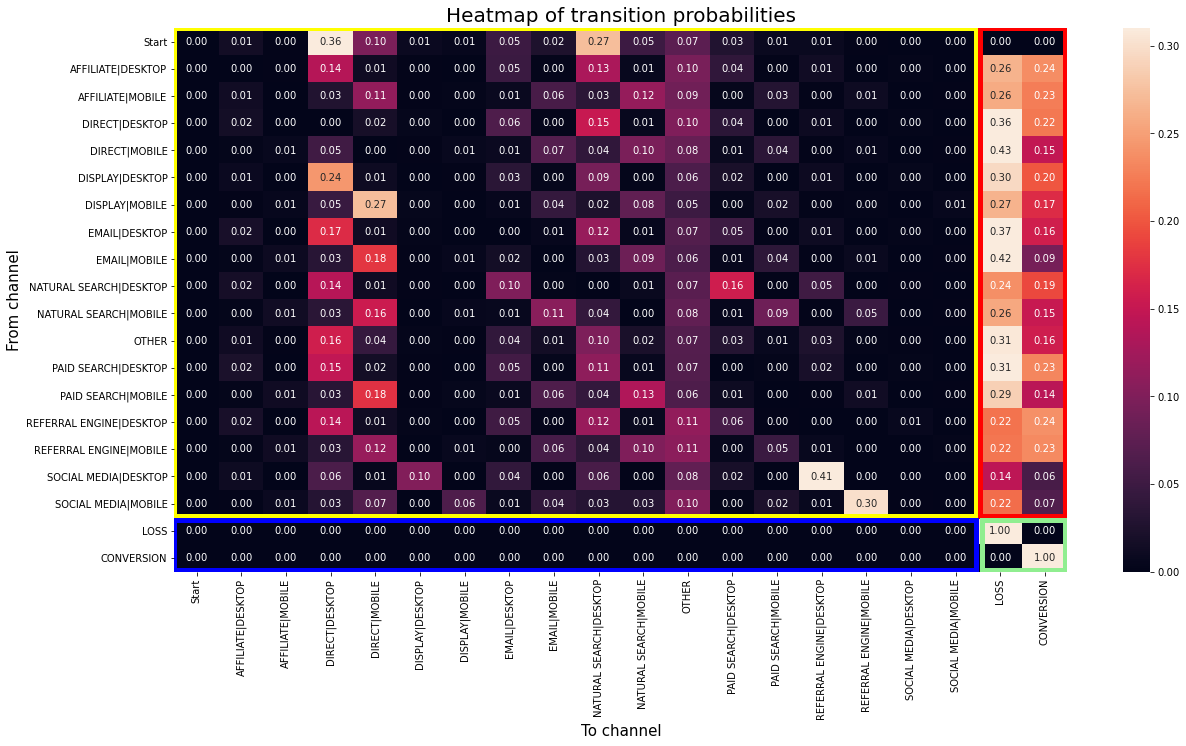

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(transitions_mat, annot = True, robust = True, fmt = ".2f")
#yellow box to indicate the transient part of the matrix
ax.add_patch(
 patches.Rectangle(
     (0, 0),
     17.95,
     17.95,
     edgecolor = 'yellow',
     fill = False,
     lw = 5))
#red box to indicate the absorbing part of the matrix
ax.add_patch(
 patches.Rectangle(
     (18.05, 0),
     1.9,
     17.95,
     edgecolor = 'red',
     fill = False,
     lw = 5))
#blue box to indicate the zero part of the matrix
ax.add_patch(
 patches.Rectangle(
     (0, 18.1),
     17.95,
     1.85,
     edgecolor = 'blue',
     fill = False,
     lw = 5))
#green box to indicate the identity part of the matrix
ax.add_patch(
 patches.Rectangle(
     (18.1, 18.1),
     1.85,
     1.85,
     edgecolor = 'lightgreen',
     fill = False,
     lw = 5))

plt.title('Heatmap of transition probabilities', fontsize = 20) # title with fontsize 20
plt.xlabel('To channel', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('From channel', fontsize = 15) # y-axis label with fontsize 15

plt.show()

The matrix shown above is the transition probability matrix. Each cell describes the transition probability form a channel in rows to a channel in columns. The heatmap coloring indicates larger probabilites with brighter colors. Notice that the sum of probabilities in each row adds up to $1$. Also, no transition to `Start` is possible since `Start` is a state from which customer journeys begin. Also, absoring states `LOSS` or `CONVERSION` have a transition probability of $1$ to transition into themselves since no transition out of them is possible.

The matrix is also broken into four smaller pieces which are denoted as: 
1. The transient matrix (yellow) includes transition probabilities of transient states of a Markov chain to and from which  a transition is possible,
2. The absorbing matrix (red) includes transition probabilities to absorbing states of the Markov chain, 
3. The zero matrix (blue) includes transition probabilities from absorbing states that, and 
4. The recurrent matrix (green) includes transition probabilities from absorbing states to absorbing states which equals and identity matrix.

Therefore, a transition probability matrix or `TPM` can also be shown as 

<br/>$$\begin{equation*}
\text{TPM} = 
\begin{pmatrix}
T_{18\times 18} & R_{18\times 2} \\
0_{2\times 18} & I_{2\times 2} \\
\end{pmatrix}_{20\times 20}
\end{equation*}$$<br/>

for a multi-touch attribution setting for 17 distinct channels (+ 1 for `Start` state) and 2 absorbing states (`LOSS` and `CONVERSION`).  

## 4. Removal effects <a name="se:removal"></a>

Attributions in Markov chains are evaluated by calculating the removal effect of one channel in conversions. Removal effects are commonly defined as the change in probability of converting at the start of the process (i.e., conversion rate) when a certain channel is removed from the process. The removal effect can be interpreted as the drop in conversion rate due to removing a channel. By dividing each channel's individual removal effect by the total sum of all removal effects, one arrives at a percent value of each removal effect which is more in line with other attribution models.

In order to calculate removal effects based on transition probability matrix, the above representation of the transition probability matrix is very helpful as absorbing probabilities are 

$$P = (I - T)^{-1}\, \cdot R,$$

where $T$ and $R$ are transient and absorbing partition of the transition probability matrix, respectively. The function `removal_effects` will calculate the removal effects according to the following steps:

1. Remove one channel from the original transition matrix; drop column and row from $\text{TPM}$
2. Sum of the rows drops below $1$. Modify transition to loss probabilities for other channels by the difference from $1$
2. Partition the reduced matrix into its transient and absorbing part; $T$ and $R$.
3. Calculate absorbing probabilities
4. Extract new conversion rate from the `Start` state
5. Normalize conversion rates to sum to $1$.

In [13]:
def removal_effects(transitions_mat, base_conversion_rate):
    import numpy as np
    from tqdm import tqdm
    RE_dict = {}
    channels = [channel for channel in transitions_mat.columns 
                            if channel not in ['Start', 'LOSS', 'CONVERSION']]
    for channel in tqdm(channels):
        #remove a channel from TPM by dropping it from rows and columns
        removal_df = transitions_mat.drop(channel, axis = 1).drop(channel, axis = 0)
        for column in removal_df.columns:
            #calculate the drop in conversion rate
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['LOSS'] += null_pct
            removal_df.loc['LOSS']['LOSS'] = 1.0
        #partition T and R matrix from the reduced transition matrix
        R = removal_df[['LOSS', 'CONVERSION']].drop(['LOSS', 'CONVERSION'], axis = 0)
        T = removal_df.drop(['LOSS', 'CONVERSION'], axis = 1).drop(['LOSS', 'CONVERSION'], axis = 0)
        I = np.identity(len(T.columns))
        #calculate absorbtion probabilities for the reduced matrix, 0: loss probabilities, 1: conversion probabilities
        P = np.dot(np.linalg.inv(I - T), np.asarray(R))
        #extract the new conversion rate from the `Start` state
        new_cr = pd.DataFrame(P, index = R.index)[[1]].loc['Start'].values[0]
        RE = 1 - new_cr / base_conversion_rate
        RE_dict[channel] = RE
    #sum of removal effects
    re_sum = np.sum(list(RE_dict.values()))
    #normalize the removal effect
    new_RE_dict = {k: v / re_sum for k, v in RE_dict.items()}
    return RE_dict, new_RE_dict

In [14]:
total_conversions = sum(path.count('CONVERSION') for path in path_df['FULL_PATH'].tolist())
base_conversion_rate = total_conversions / len(path_df['FULL_PATH'])
removal_effects_dict, normalized_removal_effects_dict = removal_effects(transitions_mat, base_conversion_rate)

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 126.41it/s]


### 4.1. Attributions <a name="sse:removal-attr"></a>

To evaluate channel attributions, normalized removal effects are multiplied by total conversions to measure out the contribution of each channel to total attribution.

In [15]:
new_attributions = {k:v  * total_conversions for k, v in normalized_removal_effects_dict.items()}
new_attributions = pd.DataFrame.from_dict(new_attributions, orient = 'index', columns = ['attribution'])
new_attributions.reset_index(inplace = True)
new_attributions.rename(columns = {'index': 'channel'}, inplace = True)
new_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
new_attributions.reset_index(drop = True, inplace = True)
new_attributions

,channel,attribution
0,DIRECT|DESKTOP,61379.125617
1,NATURAL SEARCH|DESKTOP,53628.049948
2,OTHER,24074.732248
3,PAID SEARCH|DESKTOP,17638.006768
4,EMAIL|DESKTOP,16430.034470
5,DIRECT|MOBILE,14917.657871
6,NATURAL SEARCH|MOBILE,9833.688347
7,REFERRAL ENGINE|DESKTOP,7209.572686
8,AFFILIATE|DESKTOP,6029.690231
9,EMAIL|MOBILE,4650.581721


### 4.2. QA check <a name="sse:removal-qa"></a>

One way to ensure that channel attributions are correctly calculated is to compare sum of channel attribution and total conversion. Remember that removal effects are normalized to add up to $1$ and then multiplied by total conversion. The following cell compares this sum and raises an error in case of inequality.

In [16]:
if round(new_attributions.attribution.sum()) != round(total_conversions):
    raise ValueError('Error: Markov attributions do not add up to total conversions.')

print("Total conversions: ", total_conversions)
print("Sum of Markov chain attributions: ", new_attributions.attribution.sum())

Total conversions:  224609
Sum of Markov chain attributions:  224609.0


### 4.3. Visualization <a name="sse:removal-viz"></a>

To visualize the results, a barplot is generated based on Markov attributions. <span style="color:blue;">**NOTE**</span> that the attribution are sorted in a descending order. Each bar is annotated by raw attribution and its relative percentage with respect to total utility.

new_attributions['per'] = new_attributions.attribution / new_attributions.attribution.sum()

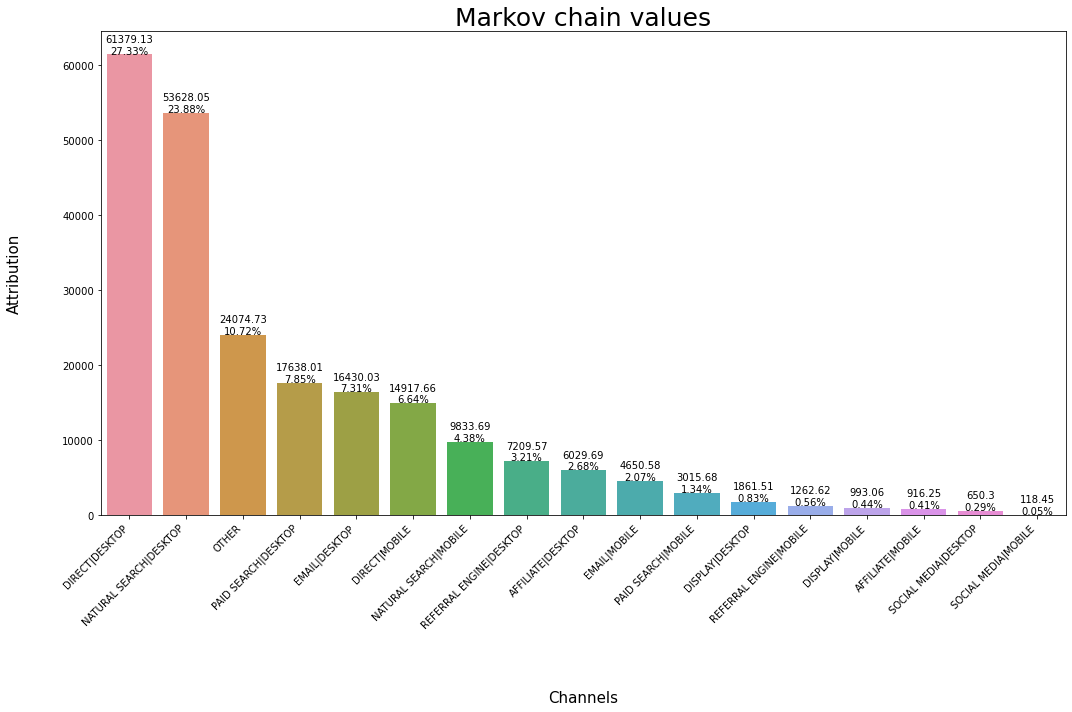

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (15, 10))
g = sns.barplot(x = 'channel', 
                y = 'attribution', 
                data = new_attributions)

for index, row in new_attributions.iterrows():
    g.text(row.name, 
           row.attribution + 100, 
           str(round(row.attribution, 2)) + "\n" + str(round(row.per * 100, 2)) + "%", 
           color = 'black', 
           ha = "center")

g.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
g.set_title('Markov chain values', fontsize = 25)
plt.xlabel("Channels", labelpad = 60, fontsize = 15)
plt.ylabel("Attribution", labelpad = 40, fontsize = 15)
plt.tight_layout()
plt.show()
plt.show()